# Building a "varying cell size grid"

## Goals

- Get familiar with the tools used by Statbel to perform some spatial analyses
- Documenting how to create the "varying cell size grid" in a didactic way. The "varying cell size grid" is a more detailed version of the [Census grid](https://ec.europa.eu/eurostat/statistics-explained/index.php?title=Population_and_housing_census_2021_-_population_grids).

In this Jupyter notebook, we focus on the most important aspects of the processing, i.e. cell splitting where this does not jeopardise data confidentiality. Some **parts of the processing are therefore not explained**:
- Cells that are uninhabited will not be represented. The grid generated here will therefore contain "holes" that will need to be filled afterwards (ie, cell with no population should be present in the final output with a population count equal to 0
- We don't show how to prevent the grid from going beyond the country's borders
- Some cells of the census grid could be anonymised because the population residing there is too low. We do not explain here how this protection is achieved.

The latter processes are not complex and could be illustrated in a future version of this notebook.

This is how the census grid looks like. It is a zoom on a portion of the territory.

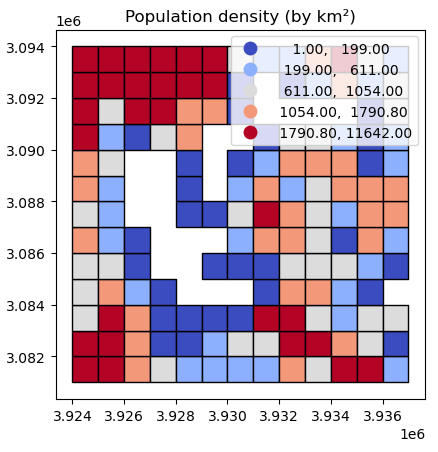

This is how the "varying cell size grid" looks like: some cells are splitted.

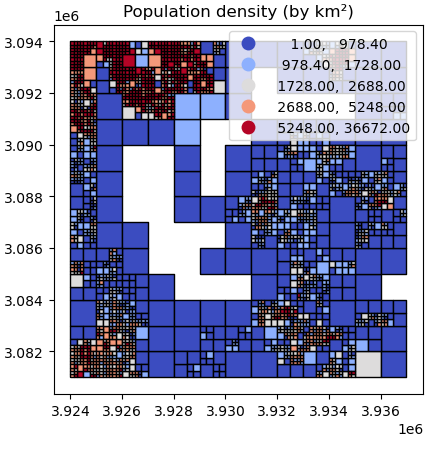





## Python imports

Packages for this project are:
- [OS](https://docs.python.org/3/library/os.html "OS") to interact with the file system
- [Pandas](https://pandas.pydata.org/) to manipulate dataFrames
- [Geopandas](https://geopandas.org/en/stable/about.html): extension of pandas to manipulate DataFrames that contain geographic data
- [NumPy](https://numpy.org) to manipulate arrays and matrices
- [SQLITE3](https://docs.python.org/3.8/library/sqlite3.html "SQLITE3") to create, query and update SQLITE databases (a serverless database system that simplifies the storage and use of relational data); 

The [libspatialite](https://www.gaia-gis.it/fossil/libspatialite/index) should also be installed. This library, developped by Alessandro Furieri, extends the *SQLite core to support fully fledged Spatial SQL capabilities*. 

All [Onyxia](https://www.onyxia.sh/) images come with these packages pre-installed.

In [1]:
import sqlite3
import os
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt # To make graphics

## Input data 

The input data consist in a **synthetic_population.csv** file. The file is located in the **input/synthetic_population/** directory. 

The **synthetic_population** data contains **one line per capita**. Variables are: 
- (x,y) coordinates
- a household identifier (id_hh)
- a person identifier (id_demo)
- code of the statistical sector

The (x,y) coordinates system is **ETRS89-extended / LAEA Europe - EPSG:3035**, ie, the coordinates system used for the **european census grid**.

These **synthetic_population** was generated according to the following criteria:
- area overlapping Walloon Brabant, Flemish Brabant and Brussels
- points located on the centroids of the buildings (buildings are included in the land register data)
- random count of points in the buildings
- population density aligned with density in statistical sectors
- ID_DEMO and ID_HH are randomly generated

The code to synthetise the population is available in the repository.

Here is a view on the data:

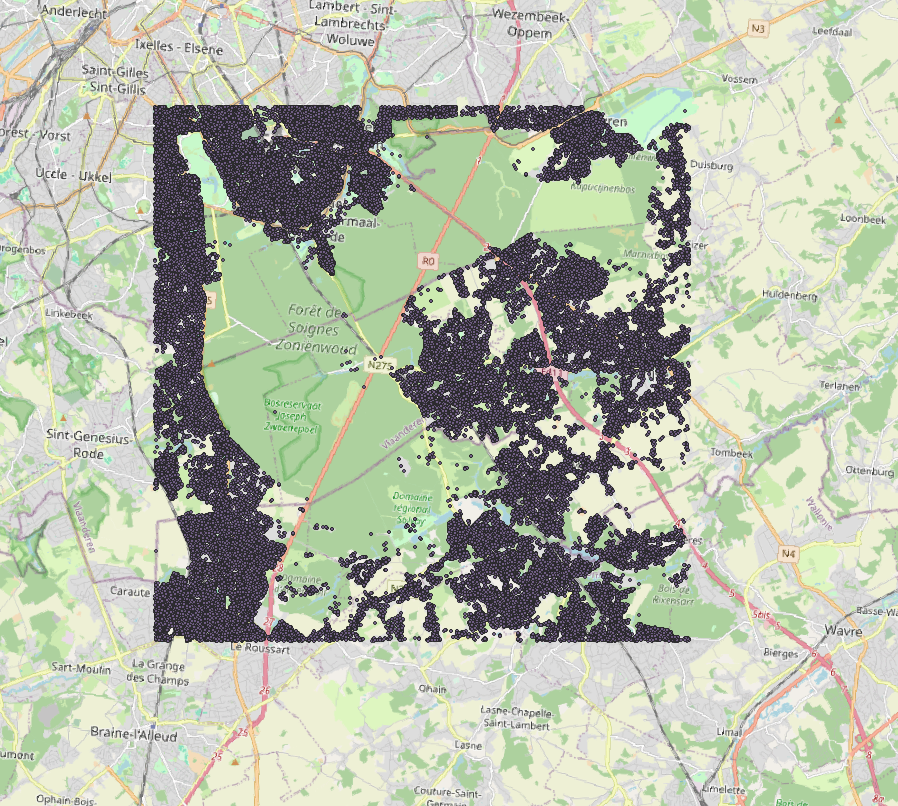

### Import csv into dataframe

In [2]:
population = pd.read_csv('input/synthetic_population/synthetic_population.csv',sep='|')

### Inspect content of dataframe

In [3]:
population.head()

,id_demo,id_hh,X,Y,cd_sector
0,0c048b3a434e49e6,0000608540e08433,3.928896e+06,3.093221e+06,21002A00-
1,138bb0696595b338,0000608540e08433,3.928896e+06,3.093221e+06,21002A00-
2,a1d0c6e83f027327,0000608540e08433,3.928896e+06,3.093221e+06,21002A00-
3,824cca8cfaf9469b,000065bda44347cc,3.936903e+06,3.086124e+06,23062A291
4,168908dd3227b835,000070a3e6444850,3.928749e+06,3.093286e+06,21002A00-


<Axes: xlabel='X', ylabel='Y'>

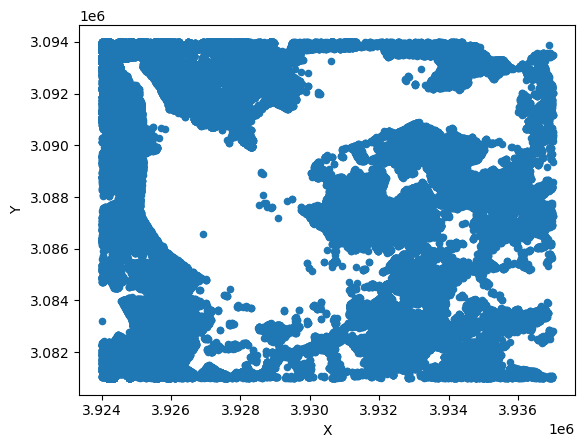

In [4]:
population.plot(x='X',y='Y',kind='scatter')

## Let us work with a SQLite database !

### Database location

Our database will be located in the /output directory. The name of the DB will be varying-cell-size-grid.sqlite.
Let us drop the file from a potential previous run.

In [5]:
if os.path.exists(f'output/varying-cell-size-grid.sqlite'):
     os.remove(f'output/varying-cell-size-grid.sqlite')

### Database creation

Let us create the database. We'll load the **mod_spatialiate** extension. This will add **spatialite** functionalities to our database.

In [6]:
database = sqlite3.connect(f'output/varying-cell-size-grid.sqlite')
database.enable_load_extension(True)
database.load_extension("mod_spatialite") # --> loads the spatialite extension 
database.execute('select InitSpatialMetaData(1);') # --> creates the metadata tables required by Spatiliate --> from that moment on, we have a fully fleged spatial database !
database.commit()

### Load population dataframe file into database

In [7]:
population.to_sql(name='T01_POPULATION',con=database,index=False,if_exists="replace")

210953

### How to query the database?

#### Example 1

In [8]:
pd.read_sql('''
select cd_sector, count(*)
from T01_population
group by 1
''',database)

,cd_sector,count(*)
0,21002A00-,1481
1,21002A01-,757
2,21002A02-,1079
3,21002A030,2032
4,21002A041,607
...,...,...
273,25119D122,235
274,25119D190,41
275,25119D200,685
276,25119D291,41


#### Example 2

Let us count the number of persons and households in the population.

In [9]:
pop,hh = database.execute(f'''
select count(distinct id_demo) as ms_population, count(distinct id_hh) as ms_countOf_hh
from T01_POPULATION
''').fetchone()

print(f"Count of persons: {pop} - Count of households: {hh}")

Count of persons: 210953 - Count of households: 86299


## Building the census grid

### Count of persons and households in each cell of the grid

In [10]:
# Count of individuals by km²
# km² identified by its lower left corner 

grid1km2=pd.read_sql('''
select floor(X/1000)*1000 as X,
       floor(Y/1000)*1000 as Y,
       '1kmN'||cast(floor(Y/1000) as int)||'E'||cast(floor(X/1000) as int) as grid_id,
       count(distinct id_demo) as ms_population,
       count(distinct id_hh)   as ms_countOf_households
from T01_population
group by 1, 2, 3
''',database)

This SQL query counts the number of persons and households in each cell of the Census grid. Here's a breakdown:

1. **Coordinate Binning:** The X and Y coordinates of individual dwellings are grouped into larger units by dividing them by 1000 and rounding down to the nearest whole number. This grouping creates a grid-like structure where each unit represents a 1000m-unit by 1000m-unit cell, ie a 1km² cell.

2. **Grid Identification (`grid_id`):** An identifier for each grid cell is created using a string format. This identifier includes information about the location of the cell within the grid, incorporating both the X and Y coordinate bins. This allows for a unique label for each cell, like '1kmN3081E3924'.

3. **Population Counting:**: The query then counts the number of persons and households within each grid cell. 

In essence, this query transforms raw dwelling coordinates (ie, place where people live) into a structured grid, assigns a unique identifier to each grid cell, and calculates the population residing in each cell. The final result provides a summarized view of population distribution across the defined grid, which can be valuable for geographic analysis and understanding how populations are distributed spatially.

Here is how the resulting table looks like:

In [11]:
grid1km2.head()

,X,Y,grid_id,ms_population,ms_countOf_households
0,3924000.0,3081000.0,1kmN3081E3924,4740,2093
1,3924000.0,3082000.0,1kmN3082E3924,1802,1035
2,3924000.0,3083000.0,1kmN3083E3924,657,337
3,3924000.0,3084000.0,1kmN3084E3924,780,376
4,3924000.0,3085000.0,1kmN3085E3924,1030,520


### Building the grid

We have a tabular representation of the Census Grid. But we would like to build maps ! 

Maps are made with geometries, ie, polygons, lines, points, .... [Well known text](https://en.wikipedia.org/wiki/Well-known_text_representation_of_geometry) makes it possible to build geometries in a spatial database.

Extract from Wikipedia page:

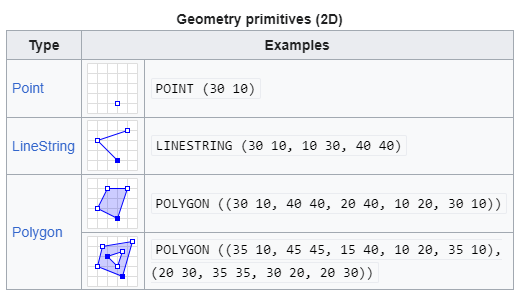

Let us develop our query to create one polygon for each cell of the grid:

In [12]:
sql='''
        /* Population by km2 */
        
        with grid_data as (
              select '1kmN'||cast(floor(Y/1000) as int)||'E'||cast(floor(X/1000) as int) as grid_id,
                     floor(X/1000)*1000 as x,
                     floor(Y/1000)*1000 as y,
                     count(distinct id_demo) as ms_population
                from T01_population
                group by 1, 2, 3
             ) 

        /* Let us create a GEOMETRY using WKT */
        
        select *,
               st_AsBinary(CastToMultiPolygon(
                  ST_GeomFromText('POLYGON(('||cast(x           as int)||' '||cast(y           as int)||','
                                             ||cast(x+1000      as int)||' '||cast(y           as int)||','
                                             ||cast(x+1000      as int)||' '||cast(y+1000      as int)||','
                                             ||cast(x           as int)||' '||cast(y+1000      as int)||','
                                             ||cast(x           as int)||' '||cast(y           as int)||'))',3035)))
                  as geometry
        from grid_data
        
'''
grid1km2 = gpd.GeoDataFrame.from_postgis(sql, database, geom_col='geometry',crs=3035)

### Visualising the grid

Let us now have a visual reprensentation of the grid:

In [13]:
grid1km2.head()

,grid_id,x,y,ms_population,geometry
0,1kmN3081E3924,3924000.0,3081000.0,4740,"MULTIPOLYGON (((3924000.000 3081000.000, 39250..."
1,1kmN3081E3925,3925000.0,3081000.0,2936,"MULTIPOLYGON (((3925000.000 3081000.000, 39260..."
2,1kmN3081E3926,3926000.0,3081000.0,1424,"MULTIPOLYGON (((3926000.000 3081000.000, 39270..."
3,1kmN3081E3927,3927000.0,3081000.0,921,"MULTIPOLYGON (((3927000.000 3081000.000, 39280..."
4,1kmN3081E3928,3928000.0,3081000.0,515,"MULTIPOLYGON (((3928000.000 3081000.000, 39290..."


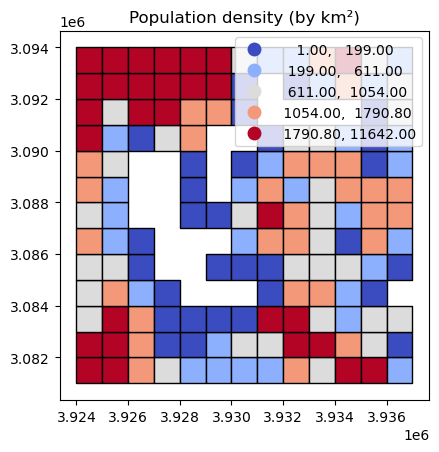

In [14]:
grid1km2.plot(column='ms_population', legend=True, cmap='coolwarm',scheme='quantiles',edgecolor='black')
plt.title('Population density (by km²)')
plt.show()

As mentionned in the introduction, you can see that some cells are not represented (white holes). Those gaps will have to be filled afterwards (not explained in this version of the notebook).

## Building the "varying cell size grid"

#### Let us compress the information a bit

More than one person could live at the same place. Let us build a table that counts the number of persons/households **by point** (ie, at each individual dwellings).

In [15]:
database.execute('drop table if exists T03_POINTS')
database.execute('''
                     create table T03_POINTS as
                     select X,
                            Y,
                            count(distinct id_demo) as ms_population,
                            count(distinct id_hh)   as ms_countof_hh
                     from T01_POPULATION
                     group by 1, 2
                ''')

In [16]:
pts, = database.execute(f'''select count(*) as population from T03_POINTS''').fetchone()

print(f"Count of points: {pts}")

Count of points: 79506


### Creation of the results table

We create here an empty table that will host the results of the process. The name of the table is **T05_RESULTS**. The (X,Y) are the coordinates of the lower left corner of a "square" polygon. The MS_LENGTH variable contains the length of the side of the square. The triplet (X,Y,MS_LENGTH) will make it possible to draw cells of different sizes, as illustrated here:

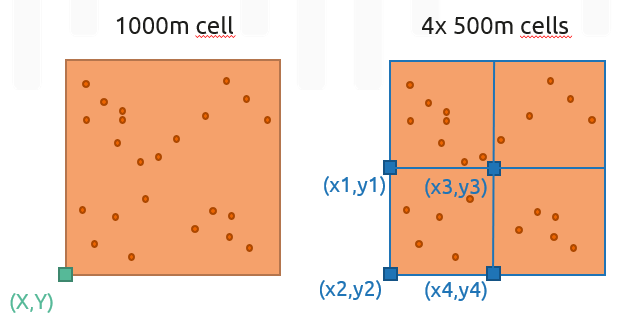

In the end, this table will contains the information need to represent the "varying cell size grid":

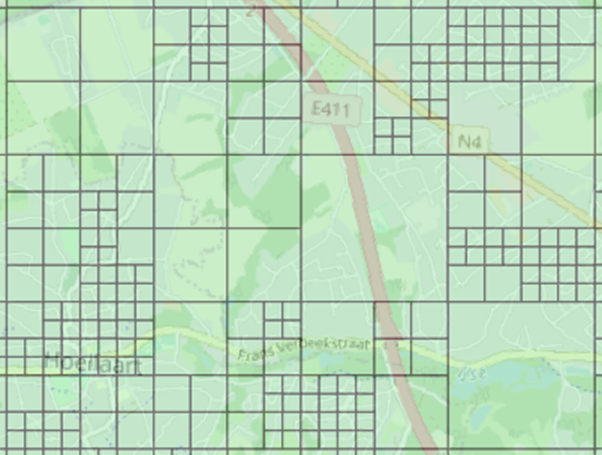


In [17]:
database.execute('drop table if exists T05_RESULTS')
database.execute('''
                    create table T05_RESULTS (
                        X             integer,
                        Y             integer,
                        MS_LENGTH     integer,
                        MS_POPULATION integer,
                        MS_COUNTOF_HH integer  )
                ''')

### Function to break cells whenever possible

We will now break cells of the Census grid into smaller cells. The desired dimensions for the cells are: 
- 1000m x 1000m
- 500m x 500m
- 250m x 250m
- 125m x 125m.

**The smaller the cells, the better !**

We create a `tryToSplitCellsWithLength(l2)` function to try to split cells into 4 sub-cells.

For a cell to be divided into 4 sub-cells, the following **confidentiality thresholds** must be met: 
- At least 10 people in each of the 4 sub-cells  
- At least 5 households in each of the 4 sub-cells

Obviously, these conditions are purely 'illustrative'. The thresholds can be adapted. 

The calculation is based on the coordinates of the bottom-left corner of a cell, which can be seen as its identifier. The units in our coordinate system are in meters. For each point, it is possible to determine the bottom-left corner of the cell as follows:

- For a 1000m*1000m cell: $( \: X_{bottom-left-corner} \: , \: Y_{bottom-left-corner} \: ) = ( \: floor(\frac{X_{point}}{1000}) \: , \: floor(\frac{Y_{point}}{1000}) \: ) $
- For a 500m*500m Cell: $ ( \: X_{bottom-left-corner} \: , \: Y_{bottom-left-corner} \: ) = ( \: floor(\frac{X_{point}}{500}) \: , \: floor(\frac{Y_{point}}{500}) \: )$
- ...

Iteratively, it is then possible to:
- Determine the coordinates of the bottom-left corner of the cell of size X (= parent).
- Determine the coordinates of the bottom-left corner of the cell of size X/2 (= child).
- Assign a privacy flag (`FL_CONFIDENTIAL`) to each child cell. `FL_CONFIDENTIAL`=1 when the thresholds are met; 0 otherwise.

If any of the 4 child sub-cells do not meet the privacy criteria, it means that division is impossible, and the parent cell of size X must be retained. The `T05_RESULTS` table is populated with information from parent cells that may not be broken down. The game is over for the population living in those cells. As a consequence, the corresponding points are deleted from the `T03_POINTS` table (ie, those points have been processed and require no further processing).

This procedure is carried out for all desired sub-cell sizes.

A function has been written to perform this operation for each dimension, where l2 corresponds to X, and l1 to X/2.

In [18]:
def tryToSplitCellsWithLength(l2):
    
    l1=int(l2/2)
    
    # Divide cells in 4 sub-cells
    database.execute(f'drop table if exists T04_AGG_{l2}')
    database.execute(f'''
              create table T04_AGG_{l2} as
              select floor(X/{l2})*{l2}            as X_PARENT,
                     floor(Y/{l2})*{l2}            as Y_PARENT,
                     {l2}                          as MS_LENGTH_PARENT,
                     floor(X/{l1})*{l1}            as X,
                     floor(Y/{l1})*{l1}            as Y,
                     {l1}                          as MS_LENGTH,
                     sum(MS_POPULATION)            as MS_POPULATION,
                     sum(MS_COUNTOF_HH)            as MS_COUNTOF_HH,
                     case
                       when sum(MS_POPULATION)>=10 and sum(MS_COUNTOF_HH)>=5 then 0
                       else 1
                      end as FL_CONFIDENTIAL
               from T03_POINTS
               group by 1, 2, 3, 4, 5, 6
               ''')
    database.commit()
    
    # "Game over" if any of the 4 child sub-cells do not meet the privacy criteria
    database.execute(f'''
              insert into T05_RESULTS (X,Y,MS_LENGTH,MS_POPULATION,MS_COUNTOF_HH)
              select X_PARENT, Y_PARENT, MS_LENGTH_PARENT, sum(MS_POPULATION), sum(MS_COUNTOF_HH)
              from T04_AGG_{l2}
              group by 1, 2, 3
              having sum(not FL_CONFIDENTIAL)<4;
              ''')
    database.commit()

    # "Game over" points are removed from the table of points to be processed
    database.execute(f'''
              delete from T03_POINTS
              where cast(floor(X/{l2})*{l2} as int)||'+'||cast(floor(Y/{l2})*{l2} as int) in (
               select distinct cast(X as int)||'+'||cast(Y as int) from T05_RESULTS)
              ''')
    database.commit()

### Building of the "varying cell size grid"

In [19]:
tryToSplitCellsWithLength(1000)
n1000 = database.execute('''select count(*) as remaining from T03_POINTS''').fetchone()[0]
print("N points restant: ", n1000)

N points restant:  69082


In [20]:
extract=pd.read_sql('''
select *
from T04_AGG_1000
where x_parent||y_parent in ( select distinct x_parent||y_parent  from T04_AGG_1000 where fl_confidential=1 )
limit 11
''',database)
extract.head(10)

,X_PARENT,Y_PARENT,MS_LENGTH_PARENT,X,Y,MS_LENGTH,MS_POPULATION,MS_COUNTOF_HH,FL_CONFIDENTIAL
0,3924000.0,3083000.0,1000,3924000.0,3083000.0,500,1,1,1
1,3924000.0,3083000.0,1000,3924500.0,3083000.0,500,221,104,0
2,3924000.0,3083000.0,1000,3924500.0,3083500.0,500,435,232,0
3,3925000.0,3090000.0,1000,3925000.0,3090000.0,500,341,155,0
4,3925000.0,3090000.0,1000,3925000.0,3090500.0,500,161,83,0
5,3925000.0,3090000.0,1000,3925500.0,3090000.0,500,2,2,1
6,3925000.0,3090000.0,1000,3925500.0,3090500.0,500,2,2,1
7,3925000.0,3091000.0,1000,3925000.0,3091000.0,500,158,73,0
8,3925000.0,3091000.0,1000,3925000.0,3091500.0,500,181,79,0
9,3925000.0,3091000.0,1000,3925500.0,3091000.0,500,13,3,1


In [21]:
tryToSplitCellsWithLength(500)
n500 = database.execute('''select count(*) as remaining from T03_POINTS''').fetchone()[0]
print(f"Remaining points: {n500}")

Remaining points: 61474


In [22]:
tryToSplitCellsWithLength(250)
n250 = database.execute('''select count(*) as remaining from T03_POINTS''').fetchone()[0]
print(f"Remaining points: {n250}")

Remaining points: 45904


In [23]:
tryToSplitCellsWithLength(125)
n125 = database.execute('''select count(*) as remaining from T03_POINTS''').fetchone()[0]
print(f"Remaining points: {n125}")

Remaining points: 18115


After `tryToSplitCellsWithLength(125)` call, the remaining points in `T03_POINTS` belong to 125m*125m cells that meet the **confidentiality thresholds**.

Let us add those points to the `T05_RESULTS` table to end the process.

In [24]:
database.execute(f'''
              insert into T05_RESULTS (X,Y,MS_LENGTH,MS_POPULATION,MS_COUNTOF_HH)
              select floor(X/125)*125, 
                     floor(Y/125)*125, 
                     125, 
                     sum(MS_POPULATION), 
                     sum(MS_COUNTOF_HH)
              from T03_POINTS
              group by 1, 2, 3''')
database.commit()

database.execute(f'''
              delete from T03_POINTS
              where cast(floor(X/125)*125 as int)||'+'||cast(floor(Y/125)*125 as int) in (
               select distinct cast(X as int)||'+'||cast(Y as int) from T05_RESULTS)
              ''')
database.commit()

In [25]:
n_remaining = database.execute(f'''select count(*) as remaining from T03_POINTS''').fetchone()[0]
print("N points restant: ", n_remaining)

N points restant:  0


### Building of the spatial table

In [26]:
database.execute('drop table if exists POP_GRID_3035')
database.execute('''
                    create table POP_GRID_3035 as
                    select *,
                           '1kmN'||cast(floor(Y/1000) as int)||'E'||cast(floor(X/1000) as int) as grid_id,
                           CastToMultiPolygon(
                              ST_GeomFromText('POLYGON(('||cast(x           as int)||' '||cast(y           as int)||','
                                                         ||cast(x+MS_LENGTH as int)||' '||cast(y           as int)||','
                                                         ||cast(x+MS_LENGTH as int)||' '||cast(y+MS_LENGTH as int)||','
                                                         ||cast(x           as int)||' '||cast(y+MS_LENGTH as int)||','
                                                         ||cast(x           as int)||' '||cast(y           as int)||'))',3035))
                              as geometry
                    from T05_RESULTS
''')

In [27]:
database.execute("select recovergeometrycolumn('POP_GRID_3035', 'geometry',3035,'MULTIPOLYGON','XY')").fetchone()
database.execute("select createSpatialIndex('POP_GRID_3035', 'geometry')").fetchone()

(1,)

### Database cleaning

Execute this code if you want to remove the "work" tables

In [28]:
database.execute("VACUUM")

## Results

### Check that we haven't lost anybody !

Vérification de la population totale (doit être égale à la population du fichier de départ)

In [29]:
ms_population_initial,ms_countOf_hh_initial = database.execute(f'''
select count(distinct id_demo) as ms_population, count(distinct id_hh) as ms_countOf_hh
from T01_POPULATION
''').fetchone()


ms_population_final,ms_countOf_hh_final=database.execute(f'''
select sum(ms_population) as ms_population, sum(ms_countOf_hh) as ms_countOf_hh
from T05_RESULTS
''').fetchone()

print(f"Initial table: ms_population={ms_population_initial} - ms_countOf_hh={ms_countOf_hh_initial}")
print(f"Final table  : ms_population={ms_population_final} - ms_countOf_hh={ms_countOf_hh_final}")



Initial table: ms_population=210953 - ms_countOf_hh=86299
Final table  : ms_population=210953 - ms_countOf_hh=86299


### Population by cell size

In [30]:
res=pd.read_sql("""select MS_LENGTH, sum(ms_population) as ms_population
                   from T05_RESULTS
                   group by 1
                """, database)
res.head()

,MS_LENGTH,ms_population
0,125,134662
1,250,36388
2,500,17874
3,1000,22029


### Statistical disclosure control

We shouldn't have 500mx500m, 250mx250m or 125mx125m cells that do not meet the confidentiality thresholds. The only cells that are allowed here are census cells (ie, 1000mx1000m cells). Please, do remember that we don't show how to protect those cells in this Jupyter notebook.


In [31]:
pd.read_sql("""
                  select *
                  from T05_RESULTS
                  where MS_POPULATION between 1 and 9
                     or MS_COUNTOF_HH between 1 and 4
            """,
            database)

,X,Y,MS_LENGTH,MS_POPULATION,MS_COUNTOF_HH
0,3926000,3086000,1000,1,1
1,3928000,3087000,1000,7,7
2,3928000,3088000,1000,4,4
3,3929000,3085000,1000,4,2
4,3930000,3091000,1000,3,2
5,3930000,3092000,1000,3,3
6,3932000,3092000,1000,6,5
7,3935000,3091000,1000,1,1


### Map representation using geopandas plot

In [32]:
sql = f"""
SELECT x, 
       y, 
       ms_length as ms_len, 
       ms_population as ms_pop, 
       ms_countof_hh as ms_hh, (ms_population+0.0)/(ms_length*ms_length)*(1000*1000) as ms_density,
       ST_AsBinary(geometry) as geometry
FROM POP_GRID_3035
"""

gdf = gpd.GeoDataFrame.from_postgis(sql, database, geom_col='geometry',crs=3035)

In [33]:
gdf.head()

,X,Y,ms_len,ms_pop,ms_hh,ms_density,geometry
0,3924000,3083000,1000,657,337,657.0,"MULTIPOLYGON (((3924000.000 3083000.000, 39250..."
1,3925000,3086000,1000,596,286,596.0,"MULTIPOLYGON (((3925000.000 3086000.000, 39260..."
2,3925000,3087000,1000,222,97,222.0,"MULTIPOLYGON (((3925000.000 3087000.000, 39260..."
3,3925000,3088000,1000,219,92,219.0,"MULTIPOLYGON (((3925000.000 3088000.000, 39260..."
4,3925000,3089000,1000,790,339,790.0,"MULTIPOLYGON (((3925000.000 3089000.000, 39260..."


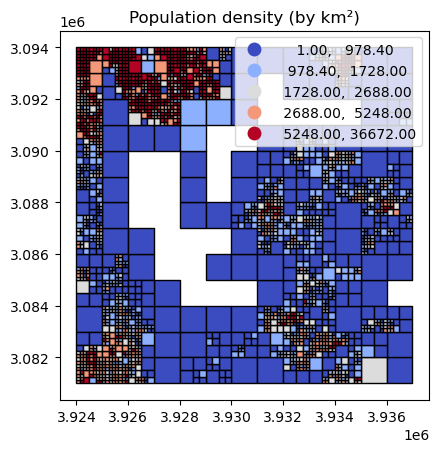

In [34]:
import matplotlib.pyplot as plt
gdf.plot(column='ms_density', legend=True, cmap='coolwarm',scheme='quantiles',edgecolor='black')
plt.title('Population density (by km²)')
plt.show()

### Export to shapefile and geojson

In [40]:
gdf.to_file('./output/POP_GRID_3035.shp')

In [41]:
gdf.to_file('./output/POP_GRID_3035.geojson', driver='GeoJSON')